In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glob
from PIL import Image
from tqdm import tqdm
import json
import math

## Load Images

In [2]:
# Load Images
bg_files = glob.glob('images/char-bgs/*.png')
puyo_files = glob.glob('images/puyo-skins/*.png')
bg_images = [np.array(Image.open(f).crop((8, 2, 392, 722))) for f in bg_files]
puyo_skins = [np.array(Image.open(f)) for f in puyo_files]

Dimensions of a character background:  (720, 384, 4)


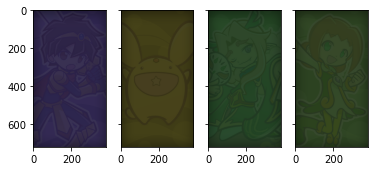

In [3]:
print('Dimensions of a character background: ', bg_images[0].shape)
fig, ax = plt.subplots(1, 4, sharey=True)
for i, j in enumerate(np.random.choice(len(bg_files), 4, replace=False)):
    ax[i].imshow(bg_images[j])
plt.show()

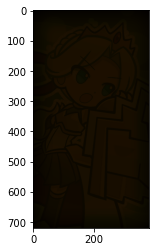

In [4]:
# Contrast stretching test
xp = [0, 32, 64, 128, 160, 192, 224, 255]
fp = [0,  0, 16, 128, 160, 192, 224, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype(np.uint8)
test_im = table[bg_images[0]]
plt.imshow(test_im)

Dimensions of a puyo skin file: (1024, 2048, 4)


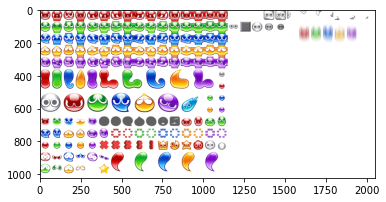

In [5]:
print('Dimensions of a puyo skin file:', puyo_skins[0].shape)
plt.imshow(puyo_skins[0])
plt.show()

## Helper functions

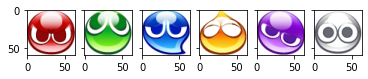

In [6]:
def get_cropped_puyos(puyo_skin: np.ndarray):
    puyos = []

    # Get colored Puyos
    for y in range(0, 72 * 5, 72):
        y0, y1 = y, y + 60
        color = []
        for x in np.arange(0, 72 * 16, 72):
            x0, x1 = x, x + 64
            color.append(puyo_skin[y0:y1, x0:x1, :])
        puyos.append(color)
    
    # Get Garbage Puyos
    y0, y1 = 72, 72 + 60
    color = []
    for x in np.arange(18 * 72, 21 * 72, 72):
        x0, x1 = x, x + 64
        color.append(puyo_skin[y0:y1, x0:x1, :])
    puyos.append(color)

    return puyos

# Test
puyos = get_cropped_puyos(puyo_skins[0])
fig, ax = plt.subplots(1, 6, sharey=True)
for i in range(len(puyos)):
    ax[i].imshow(puyos[i][0])
plt.show()

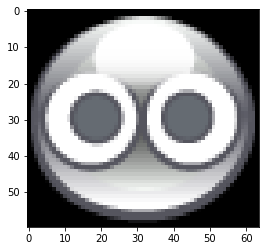

In [7]:
def alpha_blend(bg: np.ndarray, top: np.ndarray):
    '''
    https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    '''
    # # Fix alpha=0 in top layer.
    # top[:, :, :3][top[:, :, 3] == 0] = 0
    
    bg = bg.astype(np.float32) / 255.0
    top = top.astype(np.float32) / 255.0
    a = top[:, :, 3]
    a = a[:, :, np.newaxis] * np.array([1, 1, 1])
    top_rgb = top[:, :, :3]
    return np.array((top_rgb * a + bg[:, :, :3] * (1 - a)) * 255, dtype=np.uint8)

test_bg = np.ones((60, 64, 4), dtype=np.uint8) * np.array([0, 0, 0, 255])
test_im = puyos[5][0]
im_a = alpha_blend(test_bg, test_im)
plt.imshow(im_a)
plt.show()

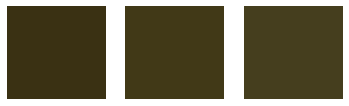

In [8]:
def get_board_cells(char_bg: np.ndarray):
    data = char_bg.reshape(-1, 4)

    cells = []
    for p in [25, 50, 75]:
        percentile_color = np.percentile(data, p, axis=0).astype(np.uint8)
        cell = np.ones((60, 64, 4), dtype=np.uint8) * percentile_color
        cells.append(cell)
    
    return cells

cells = get_board_cells(bg_images[0])
fig, ax = plt.subplots(1, len(cells))
for x in range(len(cells)):
    ax[x].imshow(cells[x])
    ax[x].axis('off')
plt.show()

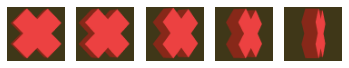

In [9]:
def get_X(char_bg: np.ndarray, puyo_skin: np.ndarray):
    # Get the spinning X
    y0, y1 = 72 * 11, 72 * 11 + 60
    spinning_Xes = []
    for x in np.arange(5 * 72, 10 * 72, 72):
        x0, x1 = x, x + 64
        spinning_Xes.append(puyo_skin[y0:y1, x0:x1, :])

    # Get mean color of char_bg
    mean_color = np.mean(char_bg.reshape(-1, 4), axis=0)
    mean_color = np.array(mean_color, dtype=np.uint8)

    cell = np.ones((60, 64, 4), dtype=np.uint8) * mean_color
    cells = []

    for spinner in spinning_Xes:
        cells.append(alpha_blend(cell, spinner))
    
    return cells

Xes = get_X(bg_images[0], puyo_skins[0])
fig, ax = plt.subplots(1, len(Xes))
for x in range(len(Xes)):
    ax[x].imshow(Xes[x])
    ax[x].axis('off')
plt.show()

## Generate all the Puyos?

In [10]:
# i = 0
# labels = []
# for puyo_skin in tqdm(puyo_skins):
#     for bg in bg_images:
#         puyos = get_cropped_puyos(puyo_skin)
#         cells = get_board_cells(bg, puyo_skin)

#         for row, color in zip(puyos, ['red', 'green', 'blue', 'yellow', 'purple', 'garbage']):
#             for puyo in row:
#                 cell = cells[0]
#                 blend = alpha_blend(cell, puyo)
#                 blend_im = Image.fromarray(blend)
#                 blend_im.save('dataset/' + str(i) + '.png')
#                 labels.append(color)
#                 i += 1

#         for c, cell in enumerate(cells):
#             cell_im = Image.fromarray(cell)
#             cell_im.save('dataset/' + str(i) + '.png')
#             if c == 0:
#                 labels.append('empty')
#             else:
#                 labels.append('X')
#             i += 1

# json.dump(labels, open('labels.json', 'w'))

In [11]:
# i = 0
# labels = []
# for puyo_skin in tqdm(puyo_skins):
#     puyos = get_cropped_puyos(puyo_skin)
#     cell = np.ones((60, 64, 4), dtype=np.uint8) * np.array([0, 0, 0, 255]) # Black background

#     for row, color in zip(puyos, ['red', 'green', 'blue', 'yellow', 'purple', 'garbage']):
#         for puyo in row:
#             blend = alpha_blend(cell, puyo)
#             blend_im = Image.fromarray(blend)
#             blend_im.save('dataset/' + color + '/puyo_' + str(i) + '.png')
#             labels.append(color)
#             i += 1

In [12]:
all_puyo = {
    'garbage': [],
    'red': [],
    'green': [],
    'blue': [],
    'yellow': [],
    'purple': []
}

for puyo_skin in tqdm(puyo_skins):
    puyos = get_cropped_puyos(puyo_skin)
    cell = np.ones((60, 64, 4), dtype=np.uint8) * np.array([0, 0, 0, 255]) # Black background

    for row, color in zip(puyos, ['red', 'green', 'blue', 'yellow', 'purple', 'garbage']):
        for puyo in row:
            blend = alpha_blend(cell, puyo)
            blend_im = Image.fromarray(blend)
            all_puyo[color].append(blend_im)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.51it/s]


In [13]:
print({k: len(all_puyo[k]) for k in all_puyo})

{'garbage': 42, 'red': 224, 'green': 224, 'blue': 224, 'yellow': 224, 'purple': 224}


In [14]:
# Augment garbage
all_puyo['garbage'] = [*all_puyo['garbage']] * 5
print({k: len(all_puyo[k]) for k in all_puyo})

{'garbage': 210, 'red': 224, 'green': 224, 'blue': 224, 'yellow': 224, 'purple': 224}


In [17]:
# Augment all colors
for color in all_puyo:
    all_puyo[color] = [*all_puyo[color]] * 4
print({k: len(all_puyo[k]) for k in all_puyo})

{'garbage': 840, 'red': 896, 'green': 896, 'blue': 896, 'yellow': 896, 'purple': 896}


In [18]:
for color in all_puyo:
    N = len(all_puyo[color])
    inds = np.arange(N)
    np.random.shuffle(inds)
    for i in tqdm(inds[:math.floor(N * 0.8)]):
        all_puyo[color][i].save('dataset/train/{c}/{num}.png'.format(c = color, num = i))
    for i in tqdm(inds[math.floor(N * 0.8):]):
        all_puyo[color][i].save('dataset/val/{c}/{num}.png'.format(c = color, num = i))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 737.71it/s]
